In [1]:
from functools import reduce
from functools import partial

import matplotlib.pyplot as plt

import numpy as np

import optuna

import pandas as pd

import pickle

from PIL import Image

import plotly

import random

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import sys

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import ConcatDataset
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

import unicodedata

from POI_engagement_classifier_utils import *

c:\Users\Lucia\.conda\envs\DeepLearningKC\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Device

In [2]:
device=(
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")

# Mostrar informaci√≥n adicional del dispositivo
if device == "cuda":
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}") #Imprime nuestra GPU
    print(f"CUDA Device Count: {torch.cuda.device_count()}") #Imprime cu√°ntas GPUs tenemos
    print(f"CUDA Device Properties: {torch.cuda.get_device_properties(0)}")

else:
    print("Using CPU")
    print(f"Number of CPU threads available: {torch.get_num_threads()}")

Using device: cuda
CUDA Device Name: NVIDIA GeForce RTX 4060 Laptop GPU
CUDA Device Count: 1
CUDA Device Properties: _CudaDeviceProperties(name='NVIDIA GeForce RTX 4060 Laptop GPU', major=8, minor=9, total_memory=8187MB, multi_processor_count=24, uuid=8e442d0f-944b-a49b-e1a7-ee0d6bb4dce0, L2_cache_size=32MB)


# Definici√≥n de semillas

In [3]:
seed = 0

set_random_seed(0)

generator = torch.Generator().manual_seed(seed)


# Importaci√≥n de datos. Exploraci√≥n inicial.

### Importaci√≥n del CSV

In [4]:
poi_dataset = pd.read_csv("poi_dataset.csv")


### Importaci√≥n de las im√°genes

In [5]:
provisional_transform = transforms.Compose([
    transforms.ToTensor(),
])


In [6]:
poi_dataset['images'] = poi_dataset['main_image_path'].apply(lambda x: load_image(x, provisional_transform))

### Exploraci√≥n Inicial de los datos

##### Tipos de cada columna del dataset

In [7]:
poi_dataset.dtypes

id                   object
name                 object
shortDescription     object
categories           object
tier                  int64
locationLon         float64
locationLat         float64
tags                 object
xps                   int64
Visits                int64
Likes                 int64
Dislikes              int64
Bookmarks             int64
main_image_path      object
images               object
dtype: object

##### Comprobaci√≥n de las dimensiones de las im√°genes

In [8]:
first_image_shape = poi_dataset['images'].iloc[0].shape

if len(poi_dataset.loc[poi_dataset['images'].apply(lambda x: x.shape != first_image_shape)])==0:
    print(f"All images have shape {first_image_shape[0]} x {first_image_shape[1]} x {first_image_shape[2]}")
else:
    print(f"Not all images have shape {first_image_shape[0]} x {first_image_shape[1]} x {first_image_shape[2]}.")


All images have shape 3 x 128 x 128


##### Comprobaci√≥n de la existencia de nulos

In [9]:
poi_dataset.isnull().sum()

id                  0
name                0
shortDescription    0
categories          0
tier                0
locationLon         0
locationLat         0
tags                0
xps                 0
Visits              0
Likes               0
Dislikes            0
Bookmarks           0
main_image_path     0
images              0
dtype: int64


# Divisi√≥n en train, validation y test

In [10]:
train_dataset, test_dataset = train_test_split(poi_dataset, test_size=0.2, random_state=seed)


In [11]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=seed)


In [12]:
print(f"Los {len(poi_dataset)} ejemplos se han dividido en:")
print(f"{len(train_dataset)} ejemplos de train")
print(f"{len(val_dataset)} ejemplos de validaci√≥n")
print(f"{len(test_dataset)} ejemplos de test")

Los 1569 ejemplos se han dividido en:
1004 ejemplos de train
251 ejemplos de validaci√≥n
314 ejemplos de test


# Exploraci√≥n de los datos en profundidad

### Datos estad√≠sticos

In [13]:
train_dataset[["xps","Visits","Likes","Dislikes","Bookmarks"]].describe()

xps        Visits         Likes      Dislikes    Bookmarks
count  1004.000000   1004.000000   1004.000000   1004.000000  1004.000000
mean    746.364542  10011.775896   3510.214143   2611.469124   944.189243
std     228.478933      5.349088   4705.211411   2307.621050  1430.781870
min       0.000000  10001.000000    104.000000     52.000000    50.000000
25%     600.000000  10008.000000    445.750000    978.000000   114.750000
50%     700.000000  10011.000000   1145.500000   2734.000000   296.000000
75%    1000.000000  10015.000000   5872.750000   3405.500000  1136.500000
max    1000.000000  10038.000000  25873.000000  10999.000000  8043.000000

### Visualizaci√≥n de algunos ejemplos

In [14]:
train_dataset.head(5).T

807  \
id                             ac7176e1-3a5f-4ce0-848e-5a936953ff1b   
name                                          Lugar de Encuentros I   
shortDescription  Descubre "Lugar de Encuentros I": una escultur...   
categories                 ['Arquitectura', 'Cultura', 'Escultura']   
tier                                                              2   
locationLon                                               -3.681167   
locationLat                                               40.431303   
tags              ['Salamanca', 'Arte', 'Fundaci√≥n juan march', ...   
xps                                                             700   
Visits                                                        10024   
Likes                                                           195   
Dislikes                                                       3250   
Bookmarks                                                       144   
main_image_path   data_main/ac7176e1-3a5f-4ce0-848e-5a936953ff1b...   
images            [[[tensor(0.4980), tensor(0.6078), tensor(0.47...   

                                                                554  \
id                             552fd663-27aa-4b91-b95d-7e4104064dff   
name                                  Monumento a Alexander Pushkin   
shortDescription  ¬°Visita la Quinta de la Fuente del Berro! Un j...   
categories                     ['Historia', 'Escultura', 'Cultura']   
tier                                                              1   
locationLon                                               -3.660858   
locationLat                                               40.424763   
tags              ['Madrid', 'Arte', 'Jard√≠n art√≠stico', 'Estatu...   
xps                                                             800   
Visits                                                        10015   
Likes                                                           411   
Dislikes                                                       3077   
Bookmarks                                                        51   
main_image_path   data_main/552fd663-27aa-4b91-b95d-7e4104064dff...   
images            [[[tensor(0.6353), tensor(0.6314), tensor(0.63...   

                                                                531  \
id                             cc35ecae-8270-4b7c-b2b9-ba00145acdc8   
name                                           Monumento al Bombero   
shortDescription  ¬°Visita "Al Bombero"! Un emotivo homenaje a lo...   
categories                     ['Escultura', 'Cultura', 'Historia']   
tier                                                              2   
locationLon                                               -3.764996   
locationLat                                               40.388012   
tags              ['Gratitud', 'Homenaje', 'Grupo escult√≥rico', ...   
xps                                                             600   
Visits                                                        10014   
Likes                                                           375   
Dislikes                                                       8980   
Bookmarks                                                       146   
main_image_path   data_main/cc35ecae-8270-4b7c-b2b9-ba00145acdc8...   
images            [[[tensor(0.6510), tensor(0.6549), tensor(0.66...   

                                                                389  \
id                             e7a8427c-46e5-4610-8244-338da0e6bb00   
name                                           Palacio L√≥pez-D√≥riga   
shortDescription  Descubre el Palacio L√≥pez-D√≥riga: elegancia ne...   
categories               ['Patrimonio', 'Historia', 'Arquitectura']   
tier                                                              2   
locationLon                                                -3.69281   
locationLat                                               40.421594   
tags              ['Evoluci√≥n', 'Rejer√≠a', 'Decoraci√≥n', 'Uso or...   
x

### Exploraci√≥n de tipos

In [15]:
train_dataset["categories"].iloc[0]

"['Arquitectura', 'Cultura', 'Escultura']"

In [16]:
train_dataset["tags"].iloc[0]

"['Salamanca', 'Arte', 'Fundaci√≥n juan march', 'Cultura', 'Escultura conceptual o abstracta', 'Arquitectura', 'Escultura', 'Naturaleza', 'Espacio p√∫blico', 'Vanguardia', 'Eduardo chillida', 'La castellana', 'Reflexi√≥n']"

Vemos que categories y tags son strigns, no listas. Esto quiere decir que aunque antes no hayamos detectado nulos puede que s√≠ contengamos listas vac√≠as convertidas a string, es decir "[]". Lo comprobamos:

### Datos sin contenido

In [17]:
print("Porcentaje de ejemplos sin categor√≠as:")
print(f"{float(poi_dataset.loc[poi_dataset["categories"]=='[]','categories'].count())*100/len(poi_dataset):.2f}%")
print("Porcentaje de ejemplos sin tags:")
print(f"{float(poi_dataset.loc[poi_dataset["tags"]=='[]','tags'].count())*100/len(poi_dataset):.2f}%")

Porcentaje de ejemplos sin categor√≠as:
0.13%
Porcentaje de ejemplos sin tags:
6.82%


### Exploraci√≥n de variables de texto

In [18]:
for i in range(30):
    print(train_dataset['shortDescription'].iloc[i])

Descubre "Lugar de Encuentros I": una escultura de Chillida que invita a la reflexi√≥n y conexi√≥n en un entorno √∫nico.
¬°Visita la Quinta de la Fuente del Berro! Un jard√≠n art√≠stico que une historia, naturaleza y la poes√≠a de Pushkin.
¬°Visita "Al Bombero"! Un emotivo homenaje a los valientes bomberos de Madrid. Celebra su hero√≠smo y dedicaci√≥n.
Descubre el Palacio L√≥pez-D√≥riga: elegancia neogriega y rica historia en el coraz√≥n de Madrid. ¬°Un tesoro arquitect√≥nico restaurado!
La Galer√≠a Xavier Fiol, fundada en 1989, centra su actividad en la promoci√≥n de las nuevas tendencias del arte contempor√°neo. 
Admira la escultura de Schultz Schreizer, homenaje a un pionero de la miner√≠a en Espa√±a, obra maestra de Fructuoso Orduna.
¬°Explora la tumba de Novosvob√≥dnaya! Un enigm√°tico dolmen de 5,000 a√±os, testigo de la antigua cultura del C√°ucaso.
Visita el osario de Sedlec, un asombroso arte funerario hecho de huesos humanos. ¬°Un destino √∫nico cerca de Praga!
La tapa m√°s c

Se podr√≠a generalizar que las descripciones son una enumeraci√≥n de caracter√≠sticas espec√≠ficas de los lugares (arte, historia, arquitectura, etc.), m√°s que en la sem√°ntica compleja o relaciones contextuales profundas. Por tanto, una red neuronal no recurrente podr√≠a ser una opci√≥n viable. 

In [19]:
for i in range(30):
    print(train_dataset['name'].iloc[i])

Lugar de Encuentros I
Monumento a Alexander Pushkin
Monumento al Bombero
Palacio L√≥pez-D√≥riga
Xavier Fiol
Escultura de Luis Guillermo Schultz Schreizer
La tumba de Novosvob√≥dnaya
El osario de Sedlec
La Tortilla de Patatas de El Pimpi
Monumento al General Mart√≠n Miguel de G√ºemes
Escultura "Encuentros"
Serra do Cand√°n
Avistamiento en el monte Rainier
Igrexa de S. Pedro Fiz do Hospital do Incio
Bar√≥
Busto de Joaqu√≠n Costa Mart√≠nez
El Castillo de Medvedgrad
Fernando III El Santo
Monumento a Miguel de Cervantes
Restos del Antiguo Palacio del Buen Retiro
Victoria Kent
Bosque de Hoia Baciu, el Tri√°ngulo de las Bermudas rumano.
Monumento a Jos√© Mar√≠a de Llanos Pastor
Hiberia
La ciudad de Cauno
Estatua de B√°rbara de Braganza
Igrexa de Santa Mar A Nova de Noia
Monumento a Vel√°zquez
Escultura "Amigos"
Palacio de los Duques de Santo√±a (C√°mara de Comercio)


Al igual que con las descripciones, en la mayor√≠a de los casos en los nombres no vemos una relaci√≥n contextual profunda, por lo que no hay necesidad de que la red neuronal sea recurrente.

### Exploraci√≥n de im√°genes

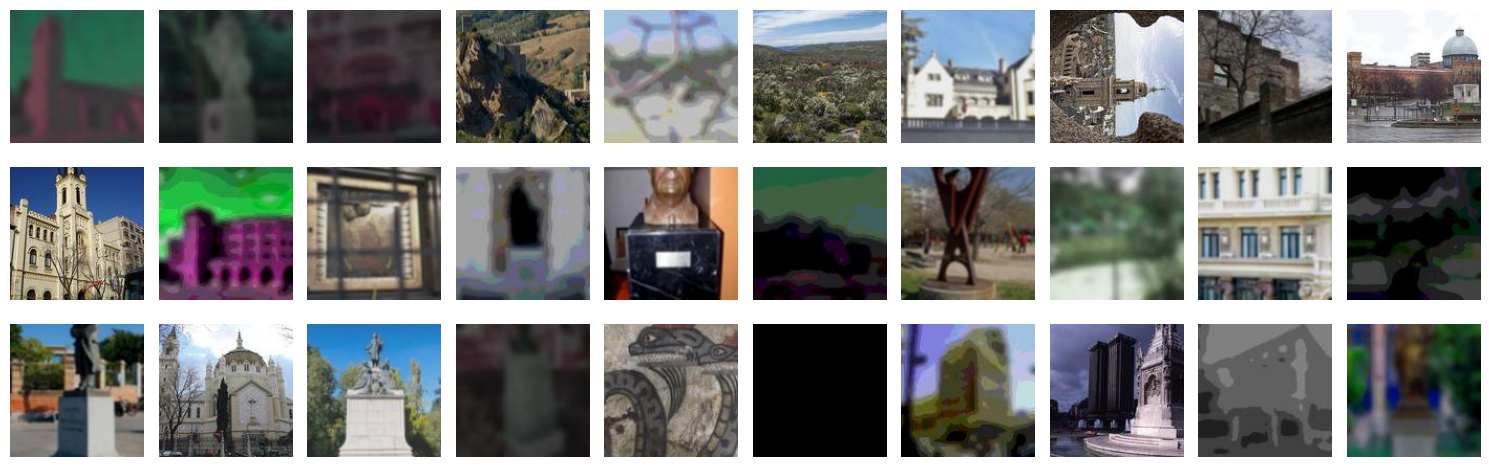

In [20]:
show_random_images(train_dataset['images'])

Vemos que algunas fotos llevan filtros de color, que hay diferencia en la calidad de las im√°genes, algunas est√°n rotadas 90¬∫, otras est√°n "escaladas" de forma que parece que solo se ve el centro de la im√°gen. Consideraremos un amplio rango de transformaciones con data augmentation para el modelo pueda aprender todas estas condiciones.

# Tratamiento de datos

### Estandarizaci√≥n de texto y tokenizaci√≥n

In [21]:
train_dataset['standarizedCategories']=train_dataset['categories'].apply(lambda x: split_text(standardize_text(x)))
val_dataset['standarizedCategories']=val_dataset['categories'].apply(lambda x: split_text(standardize_text(x)))
test_dataset['standarizedCategories']=test_dataset['categories'].apply(lambda x: split_text(standardize_text(x)))

In [22]:
print(f"N√∫mero de categor√≠as diferentes en train: {len(column_words_counter(train_dataset["standarizedCategories"] ))}")
column_words_counter(train_dataset["standarizedCategories"])

N√∫mero de categor√≠as diferentes en train: 12


{'arquitectura': 409,
 'cultura': 667,
 'escultura': 326,
 'historia': 833,
 'patrimonio': 380,
 'pintura': 27,
 'misterio': 235,
 'gastronomia': 10,
 'ocio': 45,
 'ciencia': 83,
 'cine': 14,
 'naturaleza': 25}

Aparentan ser categor√≠as definidas, por lo que tiene sentido codificarlas con Multiple Hot. De esta forma, el problema de listas vac√≠as desaparece, entendiendo que son ejemplos que no se corresponden con ninguna categor√≠a.

In [23]:
train_dataset['standarizedTags']=train_dataset['tags'].apply(lambda x: split_text(standardize_text(x)))
val_dataset['standarizedTags']=val_dataset['tags'].apply(lambda x: split_text(standardize_text(x)))
test_dataset['standarizedTags']=test_dataset['tags'].apply(lambda x: split_text(standardize_text(x)))

In [24]:
print(f"N√∫mero de tags diferentes en train: {len(column_words_counter(train_dataset["standarizedTags"] ))}")
column_words_counter(train_dataset["standarizedTags"] )

N√∫mero de tags diferentes en train: 2100


{'salamanca': 29,
 'arte': 281,
 'fundacion': 3,
 'juan': 15,
 'march': 1,
 'cultura': 406,
 'escultura': 296,
 'conceptual': 68,
 'o': 69,
 'abstracta': 68,
 'arquitectura': 378,
 'naturaleza': 91,
 'espacio': 33,
 'publico': 42,
 'vanguardia': 2,
 'eduardo': 4,
 'chillida': 2,
 'la': 41,
 'castellana': 6,
 'reflexion': 35,
 'madrid': 466,
 'jardin': 26,
 'artistico': 6,
 'estatua': 186,
 'distrito': 29,
 'intercambio': 6,
 'cultural': 67,
 'historia': 540,
 'diplomacia': 1,
 'gratitud': 2,
 'homenaje': 51,
 'grupo': 64,
 'escultorico': 64,
 'centenario': 2,
 'seguridad': 2,
 'publica': 5,
 'valor': 1,
 'bomberos': 2,
 'aguilas': 5,
 'reconocimiento': 6,
 'monumento': 119,
 'latina': 17,
 'servicio': 3,
 'evolucion': 19,
 'rejeria': 2,
 'decoracion': 27,
 'uso': 3,
 'original': 3,
 'diseno': 26,
 'interior': 7,
 'patrimonio': 259,
 'restauracion': 78,
 'luis': 9,
 'guillermo': 1,
 'schultz': 1,
 'ingenieria': 17,
 'de': 260,
 'minas': 1,
 'rios': 4,
 'rosas': 7,
 'educacion': 62,
 'fr

No parece que los tags est√©n definidos, por lo que no tiene sentido codificarlo, ya que en otros ejemplos podr√≠an ser tags totalmente diferentes.

Teniendo en cuenta que hemos descartado el tratamiento del nombre y de la descripci√≥n en su contextualizaci√≥n completa, podremos tokenizarlos a modo de una extensi√≥n de los tags del punto de inter√©s.

As√≠, solucionamos tambien el problema de listas vac√≠as en los tags.

Eliminaremos del conjunto extendido de tags las palabr√°s vac√≠as m√°s comunes, ya que son palabras que no aportan significado, por lo que como tags no tienen sentido.

In [25]:
stopwords = {standardize_text(word) for word in {
    # Preposiciones
    "a", "ante", "bajo", "cabe", "con", "contra", "de", "desde", "durante", "en", "entre", 
    "hacia", "hasta", "mediante", "para", "por", "seg√∫n", "sin", "sobre", "tras", 

    # Determinantes
    "el", "la", "los", "las", "un", "una", "unos", "unas", "mi", "mis", "tu", "tus", "su", "sus", 
    "nuestro", "nuestra", "nuestros", "nuestras", "vuestro", "vuestra", "vuestros", "vuestras",

    # Pronombres
    "yo", "t√∫", "vos", "usted", "√©l", "ella", "nosotros", "nosotras", "vosotros", "vosotras", "ustedes", 
    "ellos", "ellas", "me", "te", "se", "nos", "os", "le", "les", "lo", "los", "la", "las", "m√≠", "ti", "s√≠",

    # Conjunciones
    "y", "e", "ni", "o", "u", "pero", "sino", "aunque", "que", "porque", "pues", "ya", "como", 
    "as√≠", "luego", "mientras", "cuando", "si", "entonces", "tan", "tanto", "m√°s", "menos", "incluso",

    # Adverbios comunes
    "no", "s√≠", "tambi√©n", "tampoco", "muy", "m√°s", "menos", "poco", "mucho", "bastante", "casi", 
    "all√≠", "aqu√≠", "ah√≠", "all√°", "ahora", "antes", "despu√©s", "luego", "mientras", "adem√°s", "a√∫n", 
    "todav√≠a", "siempre", "nunca", "jam√°s", "acaso", "quiz√°", "quiz√°s",

    # Interjecciones y relleno
    "ah", "oh", "eh", "oye", "bueno", "vale", "pues", "anda", "vaya", "hombre", "claro", 
    "verdad", "entonces", "total", "seguro", "realmente", "simplemente", "evidentemente",

    # Verbos "ser", "estar", "haber" y "tener" (todas las conjugaciones)
    "ser", "soy", "eres", "es", "somos", "sois", "son", "fui", "fuiste", "fue", "fuimos", "fuisteis", "fueron",
    "era", "eras", "√©ramos", "erais", "eran", "ser√©", "ser√°s", "ser√°", "seremos", "ser√©is", "ser√°n",
    "ser√≠a", "ser√≠as", "ser√≠amos", "ser√≠ais", "ser√≠an", "siendo", "sido",
    "sea", "seas", "sea", "seamos", "se√°is", "sean",
    "fuera", "fueras", "fuera", "fu√©ramos", "fuerais", "fueran",
    "fuese", "fueses", "fuese", "fu√©semos", "fueseis", "fuesen",

    "estar", "estoy", "est√°s", "est√°", "estamos", "est√°is", "est√°n", "estuve", "estuviste", "estuvo",
    "estuvimos", "estuvisteis", "estuvieron", "estaba", "estabas", "est√°bamos", "estabais", "estaban",
    "estar√©", "estar√°s", "estar√°", "estaremos", "estar√©is", "estar√°n", "estar√≠a", "estar√≠as", "estar√≠amos",
    "estar√≠ais", "estar√≠an", "estando", "estado",
    "est√©", "est√©s", "est√©", "estemos", "est√©is", "est√©n",
    "estuviera", "estuvieras", "estuviera", "estuvi√©ramos", "estuvierais", "estuvieran",
    "estuviese", "estuvieses", "estuviese", "estuvi√©semos", "estuvieseis", "estuviesen",

    "haber", "he", "has", "ha", "hemos", "hab√©is", "han", "hube", "hubiste", "hubo", "hubimos",
    "hubisteis", "hubieron", "hab√≠a", "hab√≠as", "hab√≠amos", "hab√≠ais", "hab√≠an", "habr√©",
    "habr√°s", "habr√°", "habremos", "habr√©is", "habr√°n", "habr√≠a", "habr√≠as", "habr√≠amos",
    "habr√≠ais", "habr√≠an", "habiendo", "habido",
    "haya", "hayas", "haya", "hayamos", "hay√°is", "hayan",
    "hubiera", "hubieras", "hubiera", "hubi√©ramos", "hubierais", "hubieran",
    "hubiese", "hubieses", "hubiese", "hubi√©semos", "hubieseis", "hubiesen",

    "tener", "tengo", "tienes", "tiene", "tenemos", "ten√©is", "tienen", "tuve", "tuviste", "tuvo",
    "tuvimos", "tuvisteis", "tuvieron", "ten√≠a", "ten√≠as", "ten√≠amos", "ten√≠ais", "ten√≠an",
    "tendr√©", "tendr√°s", "tendr√°", "tendremos", "tendr√©is", "tendr√°n", "tendr√≠a", "tendr√≠as",
    "tendr√≠amos", "tendr√≠ais", "tendr√≠an", "teniendo", "tenido",
    "tenga", "tengas", "tenga", "tengamos", "teng√°is", "tengan",
    "tuviera", "tuvieras", "tuviera", "tuvi√©ramos", "tuvierais", "tuvieran",
    "tuviese", "tuvieses", "tuviese", "tuvi√©semos", "tuvieseis", "tuviesen"
}}



In [26]:
train_dataset['extendedStandarizedTags'] = train_dataset.apply(
    lambda row: (
        list(
            (
                split_text(standardize_text(row['tags']), unique_words=True)
                | split_text(standardize_text(row['shortDescription']), unique_words=True)
                | split_text(standardize_text(row['name']), unique_words=True)
            ) - stopwords
        )
    ), axis=1
)

val_dataset['extendedStandarizedTags'] = val_dataset.apply(
    lambda row: (
        list(
            (
                split_text(standardize_text(row['tags']), unique_words=True)
                | split_text(standardize_text(row['shortDescription']), unique_words=True)
                | split_text(standardize_text(row['name']), unique_words=True)
            ) - stopwords
        )
    ), axis=1
)

test_dataset['extendedStandarizedTags'] = test_dataset.apply(
    lambda row: (
        list(
            (
                split_text(standardize_text(row['tags']), unique_words=True)
                | split_text(standardize_text(row['shortDescription']), unique_words=True)
                | split_text(standardize_text(row['name']), unique_words=True)
            ) - stopwords
        )
    ), axis=1
)

In [27]:
longest_tags_length=train_dataset['extendedStandarizedTags'].apply(len).max()

print(f'The example with more "extended tags" has {longest_tags_length} tags.')

The example with more "extended tags" has 36 tags.


In [28]:
unified_set = reduce(lambda x, y: set(x) | set(y), train_dataset['extendedStandarizedTags'])

print(f"The vocabulary size is {len(unified_set)}.")

The vocabulary size is 4265.


### Codificaci√≥n de Categories

In [29]:
categories_count_dict=column_words_counter(train_dataset["standarizedCategories"])

for key in categories_count_dict.keys():
    train_dataset[key] = train_dataset["standarizedCategories"].apply(
        lambda x: 1 if key in x else 0
    )

for key in categories_count_dict.keys():
    val_dataset[key] = val_dataset["standarizedCategories"].apply(
        lambda x: 1 if key in x else 0
    )

for key in categories_count_dict.keys():
    test_dataset[key] = test_dataset["standarizedCategories"].apply(
        lambda x: 1 if key in x else 0
    )

In [30]:
train_dataset.head(1).T

807
id                                    ac7176e1-3a5f-4ce0-848e-5a936953ff1b
name                                                 Lugar de Encuentros I
shortDescription         Descubre "Lugar de Encuentros I": una escultur...
categories                        ['Arquitectura', 'Cultura', 'Escultura']
tier                                                                     2
locationLon                                                      -3.681167
locationLat                                                      40.431303
tags                     ['Salamanca', 'Arte', 'Fundaci√≥n juan march', ...
xps                                                                    700
Visits                                                               10024
Likes                                                                  195
Dislikes                                                              3250
Bookmarks                                                              144
main_image_path          data_main/ac7176e1-3a5f-4ce0-848e-5a936953ff1b...
images                   [[[tensor(0.4980), tensor(0.6078), tensor(0.47...
standarizedCategories                   [arquitectura, cultura, escultura]
standarizedTags          [salamanca, arte, fundacion, juan, march, cult...
extendedStandarizedTags  [encuentros, i, vanguardia, naturaleza, lugar,...
arquitectura                                                             1
cultura                                                                  1
escultura                                                                1
historia                                                                 0
patrimonio                                                               0
pintura                                                                  0
misterio                                                                 0
gastronomia                                                              0
ocio                                                                     0
ciencia                                                                  0
cine                                                                     0
naturaleza                                                               0

### Definici√≥n de Engagement

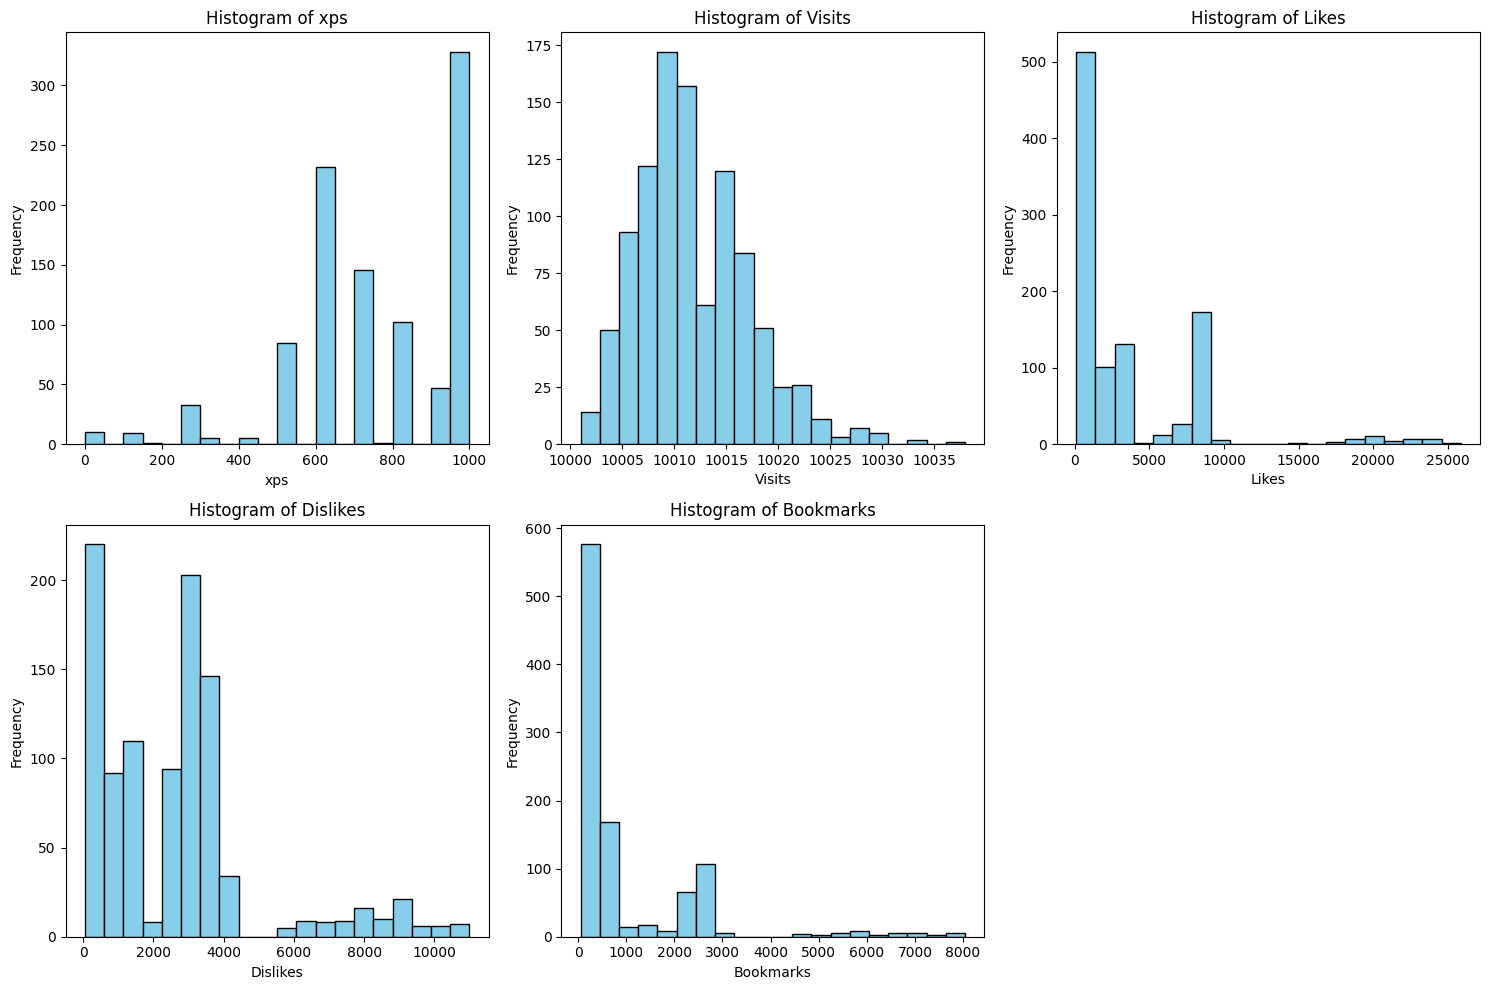

In [31]:
columns = ['xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(columns):
    axes[i].hist(train_dataset[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

if len(columns) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()

plt.show()


Vemos que hay una subida abrupta en la frecuencia de xps (experiencia de usuario) en su valor m√°ximo tras una aprente tendencia de bajada en la frecuencia. Esta falta de coherencia con la tendencia general nos lleva a desestimar su uso para la obtenci√≥n del engagement.

Teniendo en cuenta que el nivel de interacci√≥n del usuario es mucho mayor en el caso de los Likes, Dislikes y Bookmarks que en caso de las visitas, se propone la siguiente m√©trica:

$
Engagement =\frac{Likes+Bookmarks-Dislikes}{Visitas}
$

Esta m√©trica recoge el √≠ndice de aceptaci√≥n (Likes), desafecci√≥n (Dislikes) e inter√©s (Bookmarks), normaliz√°ndolo en funci√≥n de su exposici√≥n (visitas).

Esta m√©trica es un approach a la m√©trica de engagement de Redes Sociales en Marketing: (Likes + Comentarios + Compartir)/ N√∫mero de Seguidores.

La clasificaci√≥n del engagengent se har√° siguiendo tambi√©n el approach con la clasificaci√≥n de los clientes en Marketing seg√∫n el NPS (Net Promoter Score). La m√©trica de NPS son puntuaciones enteras de 0 a 10, donde las puntuaciones de 0 a 6 son clientes detractores, de 7 u 8 son neutros, y de 9 o 10 son promotores. An√°logamente, definiremos que un engagement inferior al 65% equivaldr√° a uno bajo, uno mayor o igual que 65% y menor que 85% ser√° neutro, y que uno mayor o igual que el 85% ser√° alto.




In [32]:
train_dataset['engagement'] = (
    (
        train_dataset['Likes']
        + train_dataset['Bookmarks']
        - train_dataset['Dislikes']
    )
    / train_dataset['Visits']
)

engagement_scaler = MinMaxScaler(feature_range=(0, 100))

engagement_scaler.fit(train_dataset[['engagement']])

train_dataset[['engagement']] = engagement_scaler.transform(train_dataset[['engagement']])

In [33]:
val_dataset['engagement'] = (
    (
        val_dataset['Likes']
        + val_dataset['Bookmarks']
        - val_dataset['Dislikes']
    )
    / val_dataset['Visits']
)
val_dataset[['engagement']] = engagement_scaler.transform(val_dataset[['engagement']])


test_dataset['engagement'] = (
    (
        test_dataset['Likes']
        + test_dataset['Bookmarks']
        - test_dataset['Dislikes']
    )
    / test_dataset['Visits']
)
test_dataset[['engagement']] = engagement_scaler.transform(test_dataset[['engagement']])


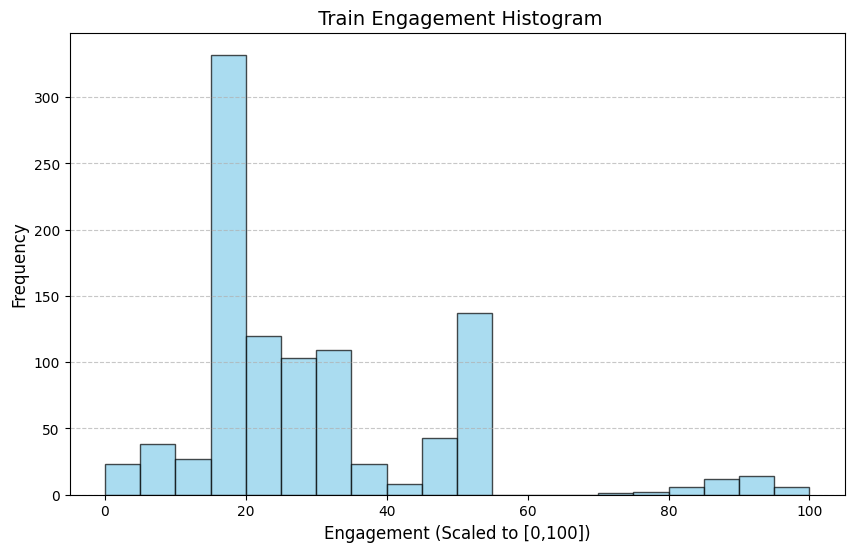

In [34]:
plt.figure(figsize=(10, 6))
plt.hist(train_dataset['engagement'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

plt.title(' Train Engagement Histogram', fontsize=14)
plt.xlabel('Engagement (Scaled to [0,100])', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [35]:
# 0 represents low, 1 represents neutral and 2 represents high

train_dataset['categoricalEngagement'] =\
    train_dataset['engagement'].apply(lambda x: 0 if x < 65 else (2 if x >= 85 else 1))

val_dataset['categoricalEngagement'] =\
    val_dataset['engagement'].apply(lambda x: 0 if x < 65 else (2 if x >= 85 else 1))

test_dataset['categoricalEngagement'] =\
    test_dataset['engagement'].apply(lambda x: 0 if x < 65 else (2 if x >= 85 else 1))

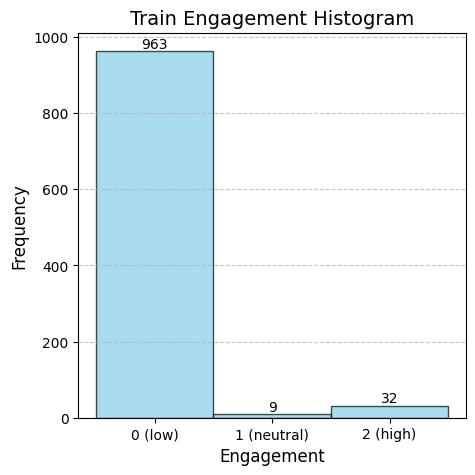

In [36]:
plt.figure(figsize=(5, 5))

bins = [0, 1, 2, 3] 

n, bins, patches = plt.hist(train_dataset['categoricalEngagement'], bins=bins, color='skyblue', edgecolor='black', alpha=0.7)

# Labels
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, 
             n[i], 
             str(int(n[i])), 
             ha='center', 
             va='bottom', 
             fontsize=10)

plt.title('Train Engagement Histogram', fontsize=14)
plt.xlabel('Engagement', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Centering labels
bar_centers = [patch.get_x() + patch.get_width() / 2 for patch in patches]
plt.xticks(bar_centers, ['0 (low)', '1 (neutral)', '2 (high)'])

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Preparaci√≥n de los Datsets. Data Augmentation y Normalizaci√≥n.

In [37]:
train_categorical_engagement = torch.tensor(train_dataset['categoricalEngagement'].values)

val_categorical_engagement = torch.tensor(val_dataset['categoricalEngagement'].values)

test_categorical_engagement = torch.tensor(test_dataset['categoricalEngagement'].values)

In [38]:
train_tags_tokens = tokens_to_padded_indices(
    datafame_column = train_dataset['extendedStandarizedTags'],
    tokens_limit=longest_tags_length,
    padding_value=0,
    hash_limit=10000
)

val_tags_tokens = tokens_to_padded_indices(
    datafame_column = val_dataset['extendedStandarizedTags'],
    tokens_limit=longest_tags_length,
    padding_value=0,
    hash_limit=10000
)

test_tags_tokens = tokens_to_padded_indices(
    datafame_column = test_dataset['extendedStandarizedTags'],
    tokens_limit=longest_tags_length,
    padding_value=0,
    hash_limit=10000
)

In [39]:
print(list(train_dataset.columns))

['id', 'name', 'shortDescription', 'categories', 'tier', 'locationLon', 'locationLat', 'tags', 'xps', 'Visits', 'Likes', 'Dislikes', 'Bookmarks', 'main_image_path', 'images', 'standarizedCategories', 'standarizedTags', 'extendedStandarizedTags', 'arquitectura', 'cultura', 'escultura', 'historia', 'patrimonio', 'pintura', 'misterio', 'gastronomia', 'ocio', 'ciencia', 'cine', 'naturaleza', 'engagement', 'categoricalEngagement']


In [40]:
train_multiple_hot_categories = torch.tensor(train_dataset[[
    'arquitectura', 
    'cultura', 
    'escultura', 
    'historia', 
    'patrimonio', 
    'pintura', 
    'misterio', 
    'gastronomia', 
    'ocio', 
    'ciencia', 
    'cine', 
    'naturaleza', 
    'engagement'
]].values, dtype=torch.float32)

val_multiple_hot_categories = torch.tensor(val_dataset[[
    'arquitectura', 
    'cultura', 
    'escultura', 
    'historia', 
    'patrimonio', 
    'pintura', 
    'misterio', 
    'gastronomia', 
    'ocio', 
    'ciencia', 
    'cine', 
    'naturaleza', 
    'engagement'
]].values, dtype=torch.float32)

test_multiple_hot_categories = torch.tensor(test_dataset[[
    'arquitectura', 
    'cultura', 
    'escultura', 
    'historia', 
    'patrimonio', 
    'pintura', 
    'misterio', 
    'gastronomia', 
    'ocio', 
    'ciencia', 
    'cine', 
    'naturaleza', 
    'engagement'
]].values, dtype=torch.float32)

In [41]:
train_images = torch.stack(train_dataset['images'].tolist())

val_images = torch.stack(val_dataset['images'].tolist())

test_images = torch.stack(test_dataset['images'].tolist())


In [42]:
train_images_mean = list(train_images.mean(axis=(0, 2, 3))) 
train_images_std = list(train_images.std(axis=(0, 2, 3)))

print(f"Las medias de las im√°genes de train por canal son: {train_images_mean[0]:.3f}, {train_images_mean[1]:.3f}, {train_images_mean[2]:.3f}")
print(f"Las desviaciones est√°ndar de las im√°genes de train por canal son {train_images_std[0]:.3f}, {train_images_std[1]:.3f}, {train_images_std[2]:.3f}")

Las medias de las im√°genes de train por canal son: 0.441, 0.438, 0.418
Las desviaciones est√°ndar de las im√°genes de train por canal son 0.267, 0.264, 0.277


Dado que tenemos muy pocos ejemplos de engagement neutro o alto, de cara a hacer data augmentation, en el caso de los engagement altos, duplicaremos los datos, manteniendo as√≠ los datos originales y haciendo las transformaciones con probabilidad de 100%. En el caso de los ejemplos con engagement bajo aplicaremos las transformaciones directamente a un porcentaje de los datos originales.

In [43]:
low_engagement_indices, neutral_engagement_indices, high_engagement_indices = [], [], []

for index, label in enumerate(train_categorical_engagement):
    if label == 0:
        low_engagement_indices.append(index)
    elif label == 1:
        neutral_engagement_indices.append(index)
    elif label == 2:
        high_engagement_indices.append(index)

Haremos las siguientes transformaciones a las im√°genes:

* Volteo horizontal
* Variaci√≥n de brillo y contraste
* Variaci√≥n de saturaci√≥n
* Rotaci√≥n aleatoria
* Traslaci√≥n aleatoria
* Escalado aleatorio
* Variaci√≥n de tono

Para intentar aproximar el numero de muestras entre bajo, medio y alto engagement clonaremos numerosas veces las muestras de engagment medio y alto. Por facilidad el n√∫mero de datasets resultante de las clonaciones ser√° un n√∫mero potencia de 2, de forma que el n√∫mero final de muestras de engagent neutro y alto se aproxime lo m√°ximo posible al n√∫mero de muestras de engagement bajo. 


In [44]:
class CustomTensorDataset(Dataset):
    
    def __init__(self, x_tokens, x_multiple_hot, x_images, y_categorical, images_transform=None):
        
        if not(len(x_tokens) == len(x_multiple_hot) == len(x_images) == len(y_categorical)):
            raise ValueError("XX and y must have the same size.")
        
        self.x_tokens = x_tokens
        self.x_multiple_hot = x_multiple_hot
        self.x_images = x_images
        self.y_categorical = y_categorical
        self.images_transform = images_transform

    def __len__(self):
        return len(self.x_tokens)

    def __getitem__(self, idx):
        x_tokens = self.x_tokens[idx]
        x_multiple_hot = self.x_multiple_hot[idx]
        x_images = self.x_images[idx]
        y_categorical = self.y_categorical[idx]

        if self.images_transform:
            x_images = self.images_transform(x_images)

        return x_tokens, x_multiple_hot, x_images, y_categorical.clone().detach().long()

In [45]:
binary_numbers_32 = [format(i, '05b') for i in range(2**5)]
binary_numbers_128 = [format(i, '07b') for i in range(2**7)]
train_subdatasets = []

for binary in binary_numbers_32:
    transform_list_32 = []

    transform_list_32.append(transforms.RandomHorizontalFlip(p=0.5))
    
    if binary[0] == '1':
        transform_list_32.append(transforms.ColorJitter(brightness=(0.2, 1.8), contrast=(0.2, 1.8)))
    
    if binary[1] == '1':
        transform_list_32.append(transforms.ColorJitter(saturation = (0.2, 1.8)))
    
    if binary[2] == '1':
        transform_list_32.append(transforms.RandomAffine(degrees=90))
    
    if binary[3] == '1':
        transform_list_32.append(transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)))
    
    if binary[4] == '1':
        transform_list_32.append(transforms.RandomAffine(degrees=0, scale=(0.5, 1.5)))
    
    transform_list_32.append(transforms.RandomApply([transforms.ColorJitter(hue=0.3)], p=0.5))
    
    transform_list_32.append(transforms.Normalize(mean=train_images_mean, std=train_images_std))
    
    
    train_subdatasets.append(CustomTensorDataset(
        x_tokens = train_tags_tokens[high_engagement_indices],
        x_multiple_hot = train_multiple_hot_categories[high_engagement_indices],
        x_images = train_images[high_engagement_indices],
        y_categorical = train_categorical_engagement[high_engagement_indices],
        images_transform=transforms.Compose(transform_list_32)
    ))


for binary in binary_numbers_128:
    transform_list_128 = []

    if binary[0] == '1':
        transform_list_128.append(transforms.RandomHorizontalFlip(p=1))
    
    if binary[1] == '1':
        transform_list_128.append(transforms.ColorJitter(brightness=(0.2, 1.8), contrast=(0.2, 1.8)))
    
    if binary[2] == '1':
        transform_list_128.append(transforms.ColorJitter(saturation = (0.2, 1.8)))
    
    if binary[3] == '1':
        transform_list_128.append(transforms.RandomAffine(degrees=90))
    
    if binary[4] == '1':
        transform_list_128.append(transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)))
    
    if binary[5] == '1':
        transform_list_128.append(transforms.RandomAffine(degrees=0, scale=(0.5, 1.5)))
    
    if binary[6] == '1':
        transform_list_128.append(transforms.ColorJitter(hue=0.3))
    
    transform_list_128.append(transforms.Normalize(mean=train_images_mean, std=train_images_std))
    
    
    train_subdatasets.append(CustomTensorDataset(
        x_tokens = train_tags_tokens[neutral_engagement_indices],
        x_multiple_hot = train_multiple_hot_categories[neutral_engagement_indices],
        x_images = train_images[neutral_engagement_indices],
        y_categorical = train_categorical_engagement[neutral_engagement_indices],
        images_transform=transforms.Compose(transform_list_128)
    ))


train_subdatasets.append(CustomTensorDataset(
    x_tokens = train_tags_tokens[low_engagement_indices],
    x_multiple_hot = train_multiple_hot_categories[low_engagement_indices],
    x_images = train_images[low_engagement_indices],
    y_categorical = train_categorical_engagement[low_engagement_indices],
    images_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply(
            [transforms.ColorJitter(brightness=(0.2, 1.8), contrast=(0.2, 1.8))],
            p=0.5
            ),
        transforms.RandomApply(
            [transforms.ColorJitter(saturation=(0.2, 1.8))],
            p=0.5
            ),
        transforms.RandomApply(
            [transforms.RandomAffine(degrees=90)],
            p=0.5
        ),
        transforms.RandomApply(
            [transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))],
            p=0.5
        ),
        transforms.RandomApply(
            [transforms.RandomAffine(degrees=0, scale=(0.5, 1.5))],
            p=0.5
        ),
        transforms.RandomApply(
            [transforms.ColorJitter(hue=0.3)],
            p=0.5
            ),
        transforms.Normalize(mean=train_images_mean, std=train_images_std)
    ])
))

train_tensor_dataset = ConcatDataset(train_subdatasets)

val_tensor_dataset=CustomTensorDataset(
    x_tokens = val_tags_tokens,
    x_multiple_hot = val_multiple_hot_categories,
    x_images = val_images,
    y_categorical = val_categorical_engagement,
    images_transform=None
)

test_tensor_dataset=CustomTensorDataset(
    x_tokens = test_tags_tokens,
    x_multiple_hot = test_multiple_hot_categories,
    x_images = test_images,
    y_categorical = test_categorical_engagement,
    images_transform=None
)

# Definici√≥n del modelo e hiperpar√°metros fijos

### Hiperpar√°metros fijos

In [46]:
# Dataloaders:
batch_size = 64

#Training:
epochs_number = 10

# Scheduler:
gamma = 0.5
decay = 0.95
step_size = 5

# Embedding:
vocabulary_size = 10000

### Modelo

In [47]:
class CombinedNet(nn.Module):
    
    
    def __init__(self, vocabulary_size, dropout_rate):
        
        super(CombinedNet, self).__init__()
        
        # Embedding branch
        # input size (train_dataset[0][0].shape): 48
        self.embedding_layer = nn.EmbeddingBag(
            num_embeddings=vocabulary_size, 
            embedding_dim=64, 
            mode='mean', 
            padding_idx=0
        ) #output_size: 64
        
        self.tags_relu_layer1 = nn.Sequential(    
            nn.BatchNorm1d(64), # output size: 64
            nn.ReLU(), # output size: 64
            nn.Dropout(dropout_rate) # output size: 64 
        )
        
        self.tags_relu_layer2 = nn.Sequential(
            nn.Linear(64, 32), #output size: 32
            nn.BatchNorm1d(32), # output size: 32
            nn.ReLU(), # output size: 32
            nn.Dropout(dropout_rate) # output size: 32
        )
        


        # Simple Branch
        #input size (train_dataset[0][1].shape): 13
        self.categories_relu_layer1 = nn.Sequential(
            nn.Linear(13, 64), #output size: 64
            nn.BatchNorm1d(64), # output size: 64
            nn.ReLU(), # output size: 64
            nn.Dropout(dropout_rate) # output size: 64
        )

        self.categories_relu_layer2 = nn.Sequential(
            nn.Linear(64, 32), #output size: 32
            nn.BatchNorm1d(32), # output size: 32
            nn.ReLU(), # output size: 32        
            nn.Dropout(dropout_rate) # output size: 32
        )
        


        #Convolutional branch
        #input size (train_images_dataset[0][2].shape): 3 x 128 x 128

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, 
                out_channels=64, 
                kernel_size=3, 
                stride=1,           
                padding=1 
            ), # output size: 64 x 128 x 128
            nn.BatchNorm2d(64), # output size: 64 x 128 x 128
            nn.ReLU(), # output size: 64 x 128 x 128
            nn.MaxPool2d(kernel_size=2, stride=2),  # output size: 64 x 64 x 64
            nn.Dropout(dropout_rate) # output size: 64 x 64 x 64
        )
        
        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=64, 
                out_channels=128, 
                kernel_size=3, 
                stride=1,           
                padding=1
            ), # output size: 128 x 64 x 64
            nn.BatchNorm2d(128), # output size: 128 x 64 x 64
            nn.ReLU(), # output size: 128 x 64 x 64
            nn.MaxPool2d(kernel_size=2, stride=2),  # output size: 128 x 32 x 32
            nn.Dropout(dropout_rate) # output size: 128 x 32 x 32
        )
        
        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, 
                out_channels=256, 
                kernel_size=3, 
                stride=1,           
                padding=1
            ), # output size: 256 x 32 x 32
            nn.BatchNorm2d(256), # output size: 256 x 32 x 32
            nn.ReLU(), # output size: 256 x 32 x 32
            nn.MaxPool2d(kernel_size=2, stride=2),  # output size: 256 x 16 x 16
            nn.Dropout(dropout_rate) # output size: 256 x 16 x 16
        )
        
        self.global_avg_pool=nn.AdaptiveAvgPool2d(1) # output size: 256 x 1 x 1
        

        
        # Clasificaci√≥n final
        self.output_fc = nn.Linear(32+32+256, 3) # output: 3 classes

    
    def forward(self, x_tokens, x_multiple_hot, x_images):

        # Tags:
        x_tokens = self.embedding_layer(x_tokens)
        x_tokens = self.tags_relu_layer1(x_tokens)
        x_tokens = self.tags_relu_layer2(x_tokens)
        
        # Categories:
        x_multiple_hot = self.categories_relu_layer1(x_multiple_hot)
        x_multiple_hot = self.categories_relu_layer2(x_multiple_hot)

        #Images:
        x_images = self.conv_layer1(x_images)
        x_images = self.conv_layer2(x_images)
        x_images = self.conv_layer3(x_images)
        x_images=self.global_avg_pool(x_images)
        x_images = x_images.view(x_images.size(0), -1)

        # Combined:
        x = torch.cat((x_tokens, x_multiple_hot, x_images), dim=1)
        x = self.output_fc(x)
        
        return x

# Optimizaci√≥n de hiperpar√°metros

### Funci√≥n objetivo

In [48]:
def objective(trial, train_dataset, val_dataset, test_dataset, epochs_number, batch_size, check_test=False):

    """
    Objective function for hyperparameter optimization using Optuna.

    Args:
        trial (optuna.trial.Trial): The trial object that Optuna uses to suggest hyperparameters.
        train_dataset (Dataset): The training dataset.
        val_dataset (Dataset): The validation dataset.
        test_dataset (Dataset): The test dataset.
        epochs_number (int): The number of epochs to train the model.
        check_test (bool, optional): If True, the model will be evaluated on the test dataset. Defaults to False.

    Returns:
        float: The validation accuracy at the end of the training.
    """
    
    print("\n==================================================================================================================================")
    
    print(f"\nIniciando Trial #{trial.number:03d}")
    print("\n----------------------------------------------------------------------------------------------------------------------------------")
    
    
    # Seed

    trial_seed = random.randint(1, 200)
    
    set_random_seed(trial_seed)
    
    trial.set_user_attr("seed", trial_seed)
    
    print(f"\nüé≤ Usando semilla: {trial_seed}")


    # Hyperparameters to optimize

    dropout_rate = trial.suggest_float("dropout_rate", 0.25, 0.5)
    
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 0.1, log=True)
    
    l1_lambda = trial.suggest_float("l1_lambda", 1e-6, 1e-4, log=True)
    
    l2_lambda = trial.suggest_float("l2_lambda", 1e-4, 1e-2, log=True)
    
    criterion_key=trial.suggest_int("criterion", 1, 3, step=1)
    

    # Dataloaders

    train_loader, val_loader, test_loader = create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size = batch_size, seed=trial_seed)
    
    
    # Model

    model = CombinedNet(vocabulary_size, dropout_rate).to(device)
    
    print(f"\nüöÄ Modelo creado y movido a {device}")


    # Optimizer, scheduler, loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

    scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)
    scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    scheduler = optim.lr_scheduler.ChainedScheduler([scheduler1,scheduler2])

    weight_tensor = torch.tensor([0.8, 1, 0.95], device=device)
    criterion={
				1: nn.CrossEntropyLoss(),
				2: nn.CrossEntropyLoss(weight = weight_tensor),
				3: nn.CrossEntropyLoss(label_smoothing=0.1)
    }[criterion_key]

    print("\nüìä Hiperpar√°metros seleccionados:")
    print(f"   - Dropout Rate: {dropout_rate:.3f}")
    print(f"   - Learning Rate: {learning_rate:.6f}")
    print(f"   - L1 lambda: {l1_lambda}")
    print(f"   - L2 lambda: {l2_lambda}")
    print(f"   - Criterion: {criterion}")

    print("\nüîÑ Datos preparados")


    # Training

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    print("\nüìà Iniciando entrenamiento:")
    print("----------------------------------------------------------------------------------------------------------------------------------")

    pbar = tqdm(range(epochs_number), desc='Training')

    for epoch in pbar:
        
        train_loss, train_acc, current_lr = train_epoch(
            model = model,
            device = device,
            train_loader = train_loader, 
            criterion = criterion,
            optimizer = optimizer,
            l1_lambda = l1_lambda,
            scheduler = scheduler
        )

        val_loss, val_acc = eval_epoch(
            model = model,
            device = device,
            val_loader = val_loader, 
            criterion= criterion
        )

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"EPOCH: #{epoch+1}")
        print(f'Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}, Current LR: {current_lr:.5f}')
        print("----------------------------------------------------------------------------------------------------------------------------------")


    # Metrics file

    with open(f"metrics_{trial_seed}.pkl", "wb") as file_i:
        
        pickle.dump(
            {
                "train_losses": train_losses, 
                "train_accs": train_accs, 
                "val_losses": val_losses, 
                "val_accs": val_accs
            }, 
            file_i
        )
    
    
    print(f"\nüíæ M√©tricas guardadas en metrics_{trial_seed}.pkl")
    

    trial.set_user_attr("metrics_path", f"metrics_{trial_seed}.pkl")
    

    # Evaluate test
    if check_test:
        accuracy = evaluate_model(
            model = model, 
            device = device, 
            test_loader = test_loader
        )
        
        print(f"\nüéØ Precisi√≥n en Test: {accuracy:.2f}%")
        
        trial.set_user_attr("test_accuracy", accuracy)

    print("\n‚ú® Trial completado ‚ú®")
    
    print(f"Precisi√≥n final en validaci√≥n: {val_accs[-1]:.2f}%")

    return val_accs[-1]

### Ejecuci√≥n del estudio

In [49]:
usual_stdout=sys.stdout

sys.stdout = open("study_log.txt", "w")

try:
    optuna.delete_study(study_name="net_optimization", storage="sqlite:///net_optimization.sqlite3")
except:
    pass

study = optuna.create_study(
    study_name="net_optimization", 
    direction="maximize", 
    storage="sqlite:///net_optimization.sqlite3", 
    sampler=optuna.samplers.TPESampler()
)

study.optimize(
    partial(
        objective, 
        train_dataset = train_tensor_dataset, 
        val_dataset = val_tensor_dataset, 
        test_dataset = test_tensor_dataset, 
        epochs_number= epochs_number,
        batch_size = batch_size
    ), 
    n_trials=100
)

sys.stdout.close()
sys.stdout = usual_stdout

[I 2025-01-25 19:09:28,265] A new study created in RDB with name: net_optimization
Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [02:51<00:00, 17.10s/it]
[I 2025-01-25 19:12:19,446] Trial 0 finished with value: 99.60159362549801 and parameters: {'dropout_rate': 0.4579354670458251, 'learning_rate': 0.0010942655179959765, 'l1_lambda': 3.7670222020668232e-06, 'l2_lambda': 0.008408916937062041, 'criterion': 1}. Best is trial 0 with value: 99.60159362549801.
Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [02:42<00:00, 16.23s/it]
[I 2025-01-25 19:15:01,797] Trial 1 finished with value: 99.60159362549801 and parameters: {'dropout_rate': 0.37295052323539013, 'learning_rate': 0.005377145903038786, 'l1_lambda': 1.4697071432365023e-05, 'l2_lambda': 0.005069621825129755, 'criterion': 2}. Best is trial 0 with value: 99.60159362549801.
Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [02:42<00:00, 16.25s/it]
[I 2025-01-25 19:17:44,347] Trial 2 finished with value: 99.20318725099601 

### Resultados del estudio

In [50]:
loaded_study = optuna.load_study(
    study_name="net_optimization",
    storage="sqlite:///net_optimization.sqlite3"
)

print(f"Estudio cargado con {len(loaded_study.trials)} trials completados")

Estudio cargado con 100 trials completados


In [51]:
optuna.visualization.plot_param_importances(loaded_study)

In [52]:
optuna.visualization.plot_optimization_history(loaded_study)

In [53]:
optuna.visualization.plot_parallel_coordinate(loaded_study)

### Elecci√≥n del trial preferido

In [59]:

completed_trials = [trial for trial in loaded_study.trials if trial.value is not None]
best_trials = sorted(completed_trials, key=lambda t: t.value, reverse=True)

print("N√∫mero de trial\t\tTrain loss\t\tVal loss\t\tTrain acc\t\tTrain acc")

for trial in best_trials:

    metrics_path = trial.user_attrs.get("metrics_path")

    with open(metrics_path, "rb") as f:
        metrics = pickle.load(f)
    
    # Filter not overfitted good metrics
    if metrics['train_losses'][-1]<1 and metrics['val_losses'][-1]<1 and metrics['train_accs'][-1]>90 and trial.value>90:
        print(f"{"#"+str(trial.number):>8}\t\t{metrics['train_losses'][-1]:>8.4f}\t\t{metrics['val_losses'][-1]:>8.4f}\t\t{metrics['train_accs'][-1]:>8.4f}\t\t{trial.value:>8.4f}")


N√∫mero de trial		Train loss		Val loss		Train acc		Train acc
     #85		  0.6513		  0.3122		 99.8407		100.0000
     #16		  0.7910		  0.3106		 99.1399		 99.6016
     #18		  0.4525		  0.3071		 99.8726		 99.6016
     #30		  0.7910		  0.3106		 99.1399		 99.6016
     #32		  0.4525		  0.3071		 99.8726		 99.6016
     #44		  0.7910		  0.3106		 99.1399		 99.6016
     #46		  0.4525		  0.3071		 99.8726		 99.6016
     #57		  0.6513		  0.3122		 99.8407		 99.6016
     #58		  0.7910		  0.3106		 99.1399		 99.6016
     #60		  0.4525		  0.3071		 99.8726		 99.6016
     #71		  0.6513		  0.3122		 99.8407		 99.6016
     #72		  0.7910		  0.3106		 99.1399		 99.6016
     #74		  0.4525		  0.3071		 99.8726		 99.6016
     #86		  0.7910		  0.3106		 99.1399		 99.6016
     #99		  0.6513		  0.3122		 99.8407		 99.6016
      #2		  0.0968		  0.0412		 99.2036		 99.2032
      #3		  0.6208		  0.3073		 99.7770		 99.2032
     #15		  0.6513		  0.3122		 99.8407		 99.2032
     #29		  0.6513		  0.3122		 99.8407		 99.2032
     #43

In [60]:
print("Chosen trial:")
trial = loaded_study.trials[85]

print("    - Validation accuracy: ", trial.value)
print("    - Par√°metros: ")
for key, value in trial.params.items():
    print(f"        - {key}: {value}")
print(f"    - Seed: {trial.user_attrs['seed']}")

Chosen trial:
    - Validation accuracy:  99.99999999999999
    - Par√°metros: 
        - dropout_rate: 0.4417003083584299
        - learning_rate: 0.0018619371013620589
        - l1_lambda: 6.197785458609027e-06
        - l2_lambda: 0.00094157395640723
        - criterion: 3
    - Seed: 176


# Reproducci√≥n del modelo elegido

### Definici√≥n de hiperpar√°metros elegidos:

In [61]:
dropout_rate = trial.params['dropout_rate']
learning_rate = trial.params['learning_rate']
l1_lambda = trial.params['l1_lambda']
l2_lambda = trial.params['l2_lambda']
criterion_key = trial.params['criterion']
random_seed = trial.user_attrs['seed']

### Definci√≥n de la semilla

In [62]:
random_seed = trial.user_attrs['seed']

set_random_seed(random_seed)

### Creaci√≥n de Dataloaders

In [63]:
train_loader, val_loader, test_loader = create_dataloaders(train_tensor_dataset, val_tensor_dataset, test_tensor_dataset, batch_size = batch_size, seed=random_seed)

### Definici√≥n del modelo

In [64]:
model = CombinedNet(vocabulary_size, dropout_rate).to(device)

### Definici√≥n de optimizador, scheduler y p√©rdida

In [65]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)
scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = optim.lr_scheduler.ChainedScheduler([scheduler1,scheduler2])

weight_tensor = torch.tensor([0.4, 1, 0.9], device=device)
criterion={
            1: nn.CrossEntropyLoss(),
            2: nn.CrossEntropyLoss(weight = weight_tensor),
            3: nn.CrossEntropyLoss(label_smoothing=0.1)
}[criterion_key]

### Entrenamiento

In [66]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

pbar = tqdm(range(epochs_number), desc='Training')

for epoch in pbar:
    
    train_loss, train_acc, current_lr = train_epoch(
        model = model,
        device = device,
        train_loader = train_loader, 
        criterion = criterion,
        optimizer = optimizer,
        l1_lambda = l1_lambda,
        scheduler = scheduler
    )

    val_loss, val_acc = eval_epoch(
        model = model,
        device = device,
        val_loader = val_loader, 
        criterion= criterion,
        confusion_matrix=True
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
   
    pbar.set_postfix({
        'EPOCH': f'{epoch+1}'
    })
    
    print(f'Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}, Current LR: {current_lr:.5f}')

    print("----------------------------------------------------------------------------------------------------------------------------------")

Training:  10%|‚ñà         | 1/10 [00:16<02:25, 16.21s/it, EPOCH=1]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  0  2
2    0  0  4
Train loss: 3.7628674013442236, Train acc: 78.97419560369543, Val loss: 0.32614842757760765, Val acc: 99.20318725099601, Current LR: 0.00177
----------------------------------------------------------------------------------------------------------------------------------


Training:  20%|‚ñà‚ñà        | 2/10 [00:31<02:05, 15.74s/it, EPOCH=2]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  0  2
2    0  0  4
Train loss: 3.156140933412015, Train acc: 94.83912073908887, Val loss: 0.31346098253451493, Val acc: 99.20318725099601, Current LR: 0.00168
----------------------------------------------------------------------------------------------------------------------------------


Training:  30%|‚ñà‚ñà‚ñà       | 3/10 [00:47<01:51, 15.89s/it, EPOCH=3]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.835717246045577, Train acc: 97.61070404587447, Val loss: 0.3112477271917807, Val acc: 99.99999999999999, Current LR: 0.00160
----------------------------------------------------------------------------------------------------------------------------------


Training:  40%|‚ñà‚ñà‚ñà‚ñà      | 4/10 [01:04<01:37, 16.18s/it, EPOCH=4]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    1  1  0
2    0  0  4
Train loss: 2.605704897108561, Train acc: 97.48327492832112, Val loss: 0.3083785914804831, Val acc: 99.60159362549801, Current LR: 0.00152
----------------------------------------------------------------------------------------------------------------------------------


Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 5/10 [01:21<01:22, 16.42s/it, EPOCH=5]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  1  1
2    0  0  4
Train loss: 2.3961583775826876, Train acc: 98.7894233832431, Val loss: 0.31055126235304603, Val acc: 99.60159362549801, Current LR: 0.00072
----------------------------------------------------------------------------------------------------------------------------------


Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 6/10 [01:37<01:06, 16.50s/it, EPOCH=6]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    1  1  0
2    0  0  4
Train loss: 2.2590958037624014, Train acc: 98.85313794201979, Val loss: 0.30952449588186715, Val acc: 99.60159362549801, Current LR: 0.00068
----------------------------------------------------------------------------------------------------------------------------------


Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 7/10 [01:54<00:49, 16.62s/it, EPOCH=7]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.1788653531398077, Train acc: 99.01242433896148, Val loss: 0.30754412692856503, Val acc: 99.99999999999999, Current LR: 0.00065
----------------------------------------------------------------------------------------------------------------------------------


Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 8/10 [02:11<00:33, 16.60s/it, EPOCH=8]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.106380003658439, Train acc: 99.23542529467984, Val loss: 0.3067213835944217, Val acc: 99.99999999999999, Current LR: 0.00062
----------------------------------------------------------------------------------------------------------------------------------


Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 9/10 [02:27<00:16, 16.49s/it, EPOCH=9]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.0443705101991463, Train acc: 99.20356801529154, Val loss: 0.3086487571319261, Val acc: 99.99999999999999, Current LR: 0.00059
----------------------------------------------------------------------------------------------------------------------------------


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 10/10 [02:43<00:00, 16.38s/it, EPOCH=10]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.9799209633766748, Train acc: 99.29913985345657, Val loss: 0.3081987398079192, Val acc: 99.99999999999999, Current LR: 0.00028
----------------------------------------------------------------------------------------------------------------------------------


### Resultados del entrenamiento

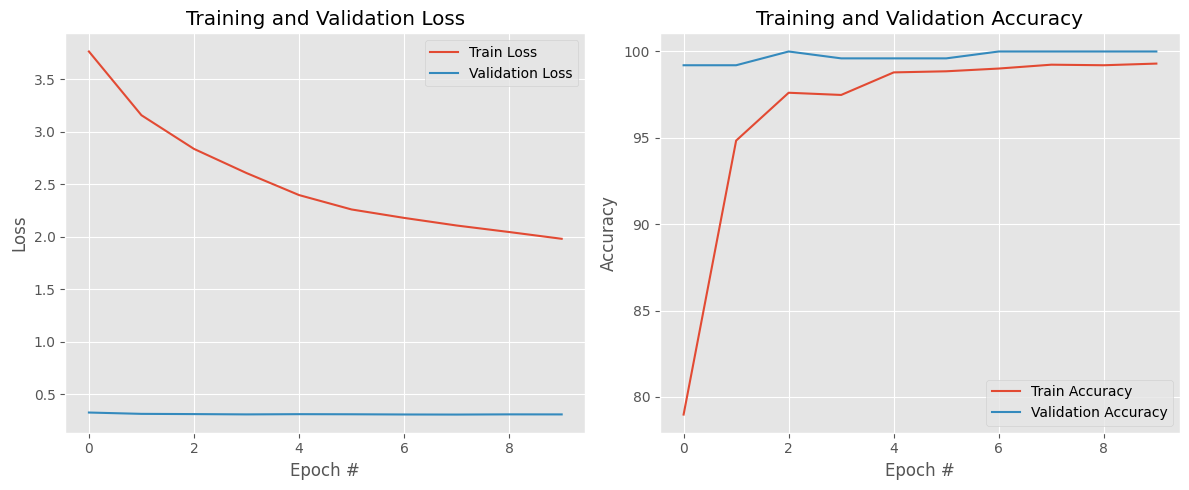

In [67]:
plot_training_curves(
    train_losses = train_losses,
    num_epochs = epochs_number,
    train_accs = train_accs, 
    val_losses = val_losses,
    val_accs = val_accs,
    test_acc=None
)


Vemos que la p√©rdida del modelo es baja mientras que el accuracy es muy alto. Dado que parece que el modelo a√∫n tiene alguna muestra que aprender en train, probamos a aumentar el n√∫mero de epochs.

# Definici√≥n y entrenamiento del modelo ajustado

##### Modificaci√≥n de Hiperpar√°metros

In [68]:
epochs_number = 20

##### Reestablecimiento del modelo

In [69]:
model = CombinedNet(vocabulary_size, dropout_rate).to(device)

##### Reestablecimiento de optimizador, scheduler y p√©rdida

In [70]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay)
scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = optim.lr_scheduler.ChainedScheduler([scheduler1,scheduler2])

weight_tensor = torch.tensor([0.8, 1, 0.95], device=device)
criterion={
            1: nn.CrossEntropyLoss(),
            2: nn.CrossEntropyLoss(weight = weight_tensor),
            3: nn.CrossEntropyLoss(label_smoothing=0.1)
}[criterion_key]

##### Entrenamiento

In [71]:
train_losses = []
train_accs = []
val_losses = []
val_accs = []

pbar = tqdm(range(epochs_number), desc='Training')

for epoch in pbar:
    
    train_loss, train_acc, current_lr = train_epoch(
        model = model,
        device = device,
        train_loader = train_loader, 
        criterion = criterion,
        optimizer = optimizer,
        l1_lambda = l1_lambda,
        scheduler = scheduler
    )

    val_loss, val_acc = eval_epoch(
        model = model,
        device = device,
        val_loader = val_loader, 
        criterion= criterion,
        confusion_matrix=True
    )

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    pbar.set_postfix({
        'EPOCH': f'{epoch+1}'
    })
    
    print(f'Train loss: {train_loss}, Train acc: {train_acc}, Val loss: {val_loss}, Val acc: {val_acc}, Current LR: {current_lr:.5f}')

    print("----------------------------------------------------------------------------------------------------------------------------------")

Training:   5%|‚ñå         | 1/20 [00:15<05:03, 15.99s/it, EPOCH=1]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 3.7402383150208256, Train acc: 81.71392163109267, Val loss: 0.35296710981315826, Val acc: 99.99999999999999, Current LR: 0.00177
----------------------------------------------------------------------------------------------------------------------------------


Training:  10%|‚ñà         | 2/20 [00:31<04:39, 15.50s/it, EPOCH=2]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 3.139207474932468, Train acc: 95.85855367951577, Val loss: 0.3130051967394779, Val acc: 99.99999999999999, Current LR: 0.00168
----------------------------------------------------------------------------------------------------------------------------------


Training:  15%|‚ñà‚ñå        | 3/20 [00:46<04:25, 15.65s/it, EPOCH=3]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    1  1  0
2    0  0  4
Train loss: 2.8318247006705843, Train acc: 97.51513220770948, Val loss: 0.3233994345266031, Val acc: 99.60159362549801, Current LR: 0.00160
----------------------------------------------------------------------------------------------------------------------------------


Training:  20%|‚ñà‚ñà        | 4/20 [01:03<04:17, 16.08s/it, EPOCH=4]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  1  1
2    0  0  4
Train loss: 2.599954970287798, Train acc: 98.08856323669961, Val loss: 0.3106379628893864, Val acc: 99.60159362549801, Current LR: 0.00152
----------------------------------------------------------------------------------------------------------------------------------


Training:  25%|‚ñà‚ñà‚ñå       | 5/20 [01:20<04:04, 16.29s/it, EPOCH=5]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.3916479682193206, Train acc: 98.94870978018479, Val loss: 0.307252232534477, Val acc: 99.99999999999999, Current LR: 0.00072
----------------------------------------------------------------------------------------------------------------------------------


Training:  30%|‚ñà‚ñà‚ñà       | 6/20 [01:37<03:49, 16.43s/it, EPOCH=6]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.25977910632121, Train acc: 98.91685250079648, Val loss: 0.307247586578012, Val acc: 99.99999999999999, Current LR: 0.00068
----------------------------------------------------------------------------------------------------------------------------------


Training:  35%|‚ñà‚ñà‚ñà‚ñå      | 7/20 [01:53<03:34, 16.48s/it, EPOCH=7]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.178804976122134, Train acc: 99.07613889773815, Val loss: 0.30580289549086676, Val acc: 99.99999999999999, Current LR: 0.00065
----------------------------------------------------------------------------------------------------------------------------------


Training:  40%|‚ñà‚ñà‚ñà‚ñà      | 8/20 [02:10<03:17, 16.46s/it, EPOCH=8]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 2.1120994410039358, Train acc: 98.78942338324309, Val loss: 0.30679685482940827, Val acc: 99.99999999999999, Current LR: 0.00062
----------------------------------------------------------------------------------------------------------------------------------


Training:  45%|‚ñà‚ñà‚ñà‚ñà‚ñå     | 9/20 [02:26<03:00, 16.44s/it, EPOCH=9]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    1  1  0
2    0  0  4
Train loss: 2.043734422721997, Train acc: 99.20356801529155, Val loss: 0.3095296382666584, Val acc: 99.60159362549801, Current LR: 0.00059
----------------------------------------------------------------------------------------------------------------------------------


Training:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà     | 10/20 [02:43<02:45, 16.55s/it, EPOCH=10]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.9820686594321113, Train acc: 99.23542529467986, Val loss: 0.31158811233908057, Val acc: 99.99999999999999, Current LR: 0.00028
----------------------------------------------------------------------------------------------------------------------------------


Training:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 11/20 [02:59<02:28, 16.54s/it, EPOCH=11]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.9372707483076526, Train acc: 99.29913985345654, Val loss: 0.3048589376814337, Val acc: 99.99999999999999, Current LR: 0.00026
----------------------------------------------------------------------------------------------------------------------------------


Training:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 12/20 [03:16<02:12, 16.55s/it, EPOCH=12]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.90970448211106, Train acc: 99.20356801529151, Val loss: 0.3056706522565439, Val acc: 99.99999999999999, Current LR: 0.00025
----------------------------------------------------------------------------------------------------------------------------------


Training:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 13/20 [03:33<01:56, 16.58s/it, EPOCH=13]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.8814586123754817, Train acc: 99.39471169162158, Val loss: 0.3047394327433461, Val acc: 99.99999999999999, Current LR: 0.00024
----------------------------------------------------------------------------------------------------------------------------------


Training:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà   | 14/20 [03:49<01:39, 16.62s/it, EPOCH=14]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.85589735030976, Train acc: 99.61771264733996, Val loss: 0.3067749218636775, Val acc: 99.99999999999999, Current LR: 0.00023
----------------------------------------------------------------------------------------------------------------------------------


Training:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 15/20 [04:06<01:22, 16.59s/it, EPOCH=15]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.8367028848575766, Train acc: 99.17171073590319, Val loss: 0.3026815139914889, Val acc: 99.99999999999999, Current LR: 0.00011
----------------------------------------------------------------------------------------------------------------------------------


Training:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà  | 16/20 [04:22<01:06, 16.55s/it, EPOCH=16]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.8160203256664775, Train acc: 99.45842625039825, Val loss: 0.3058653528471867, Val acc: 99.99999999999999, Current LR: 0.00010
----------------------------------------------------------------------------------------------------------------------------------


Training:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå | 17/20 [04:39<00:49, 16.53s/it, EPOCH=17]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.807467751003216, Train acc: 99.13985345651484, Val loss: 0.30431533085397516, Val acc: 99.99999999999999, Current LR: 0.00010
----------------------------------------------------------------------------------------------------------------------------------


Training:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 18/20 [04:55<00:33, 16.51s/it, EPOCH=18]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.7967403238842774, Train acc: 99.39471169162157, Val loss: 0.3085305598152586, Val acc: 99.99999999999999, Current LR: 0.00009
----------------------------------------------------------------------------------------------------------------------------------


Training:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå| 19/20 [05:12<00:16, 16.54s/it, EPOCH=19]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.7858199871964962, Train acc: 99.55399808856328, Val loss: 0.3067002710830643, Val acc: 99.99999999999999, Current LR: 0.00009
----------------------------------------------------------------------------------------------------------------------------------


Training: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [05:28<00:00, 16.44s/it, EPOCH=20]

Matriz de Confusi√≥n:
     0  1  2
0  245  0  0
1    0  2  0
2    0  0  4
Train loss: 1.7791311726064278, Train acc: 99.26728257406822, Val loss: 0.30387680369069375, Val acc: 99.99999999999999, Current LR: 0.00004
----------------------------------------------------------------------------------------------------------------------------------


### Resultados del entrenamiento

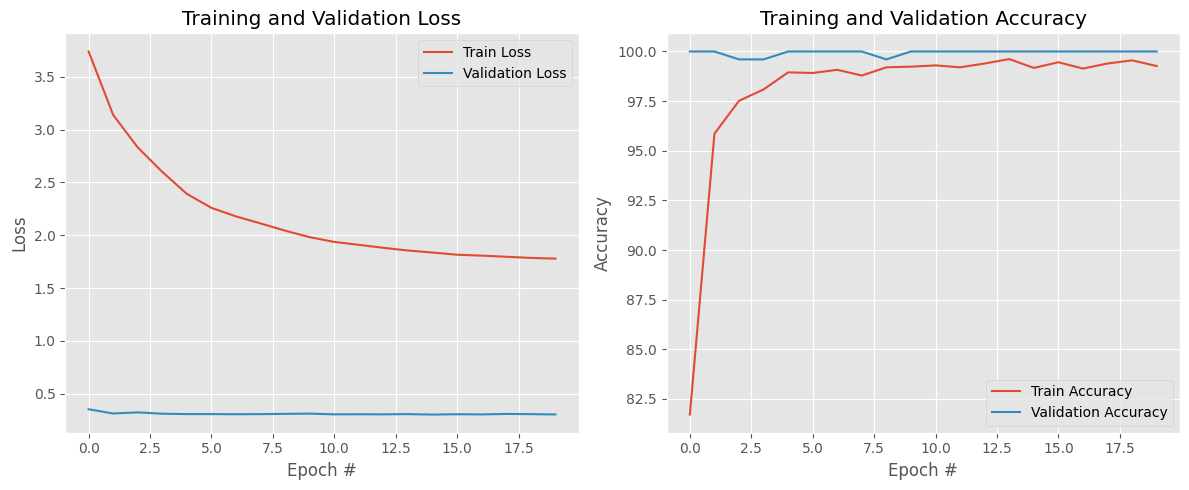

In [72]:
plot_training_curves(
    train_losses = train_losses,
    num_epochs = epochs_number,
    train_accs = train_accs, 
    val_losses = val_losses,
    val_accs = val_accs,
    test_acc=None
)

El modelo parece haberse estabilizado con un accuracy del 100% en validation y de poco m√°s del 99% en training. Estos datos son realmente buenos. Guardamos el modelo entrenado.

In [73]:
torch.save(model.state_dict(), "trained_model.pth")

# Evaluaci√≥n del modelo en test

Matriz de Confusi√≥n:
     0  1   2
0  294  0   0
1    0  0   5
2    0  0  15
La precisi√≥n del modelo en test es del 98.408%


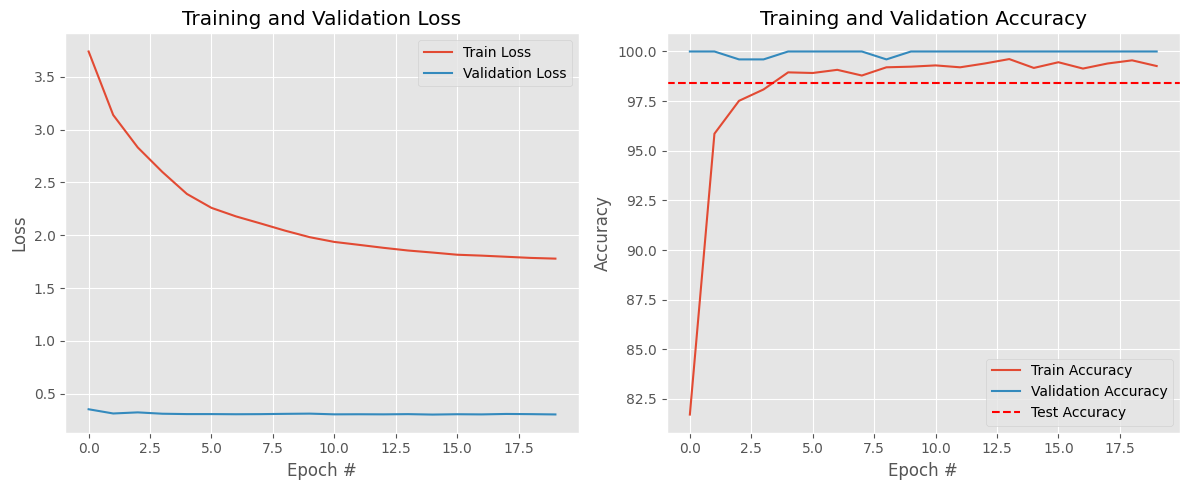

In [74]:
test_acc = evaluate_model(
    model = model, 
    device = device, 
    test_loader = test_loader,
    confusion_matrix = True
)
print(f"La precisi√≥n del modelo en test es del {test_acc:.3f}%")

plot_training_curves(
    train_losses = train_losses,
    num_epochs = epochs_number,
    train_accs = train_accs, 
    val_losses = val_losses,
    val_accs = val_accs,
    test_acc=test_acc
)

Podemos sacar las siguientes conclusiones:

* El accuracy general es notablemnte alto.

* El modelo clasifica bien los datos de engagement bajo.

* El modelo no clasifica del todo bien los datos de engagement alto, mostrando cierta incertidumbre en su clasificaci√≥n entre engagement alto o neutro. En los ejemplos de test ha dado 5 casos de falso positivo de engagement neutro, o lo que es lo mismo, 5 casos de falso negativo de engagement alto, siendo esto un 25% de error de clasificaci√≥n de los datos de engagement alto. Por otra parte, no observamos errores de predicci√≥n extremos (predicci√≥n de engagement bajo con target real de engagement alto).

* No podemos concluir nada con certeza sobre c√≥mo realiza la clasificaci√≥n de datos con engagement neutro, ya que el Dataset de test no dispon√≠a de estos datos por la imposibilidad de estratificar en la divisi√≥n de los datos (no se pudo estratificar porque la m√©trica de engagement elegida requiere de escalado MinMax, lo cual debe hacerse en funci√≥n de los datos de train). Aunque sepamos que en validation se han clasificado bien, no podemos tomarlo como m√©trica, ya que al haber utilizado las m√©tricas de validaci√≥n como objetivo de optimizaci√≥n de hiperpar√°metros y haber sido estas un factor clave en la elecci√≥n del modelo, evaluar el modelo final seg√∫n los datos de validaci√≥n ser√≠a sesgar esta evaluaci√≥n.